<a href="https://colab.research.google.com/github/saktiworkstation/Belajar-React-Satu/blob/main/Percobaan_GNN_Graph_Sage_%2B_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pada dasarnya saya Mengambil keputusan untuk terus menambahkan kerumitan pada riset ini agar hasil dari riset ini akan relevan untuk waktu yang lebih lama, dengan hasil yang baik.

In [1]:
!pip install torch-geometric
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.7 MB/s eta 0:00:00


In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import from_networkx

In [4]:
url = "http://snap.stanford.edu/data/wiki-Vote.txt.gz"
!wget -q {url} -O wiki-vote.txt.gz

graph = nx.read_edgelist("wiki-vote.txt.gz", create_using=nx.DiGraph())

print(f"Number of nodes in the graph: {graph.number_of_nodes()}")

Number of nodes in the graph: 7115


# EDA

Graph Information:
Number of nodes: 7115
Number of edges: 103689


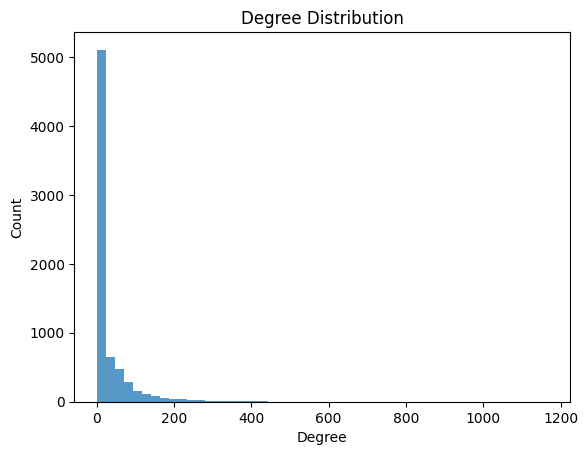

Largest Connected Component Size: 1300
Clustering coefficient is not defined for directed graphs.


In [11]:
def eda_graph(graph):
    print("Graph Information:")
    print(f"Number of nodes: {graph.number_of_nodes()}")
    print(f"Number of edges: {graph.number_of_edges()}")

    # Degree distribution
    degrees = [d for n, d in graph.degree()]
    plt.hist(degrees, bins=50, alpha=0.75)
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.show()

    # Check for connected components
    if nx.is_directed(graph):
        largest_cc = max(nx.strongly_connected_components(graph), key=len)
    else:
        largest_cc = max(nx.connected_components(graph), key=len)
    print(f"Largest Connected Component Size: {len(largest_cc)}")

    # Average clustering coefficient
    if not nx.is_directed(graph):
        print(f"Average Clustering Coefficient: {nx.average_clustering(graph)}")
    else:
        print("Clustering coefficient is not defined for directed graphs.")

# Perform EDA
eda_graph(graph)

**Mempersiapkan data | Data Preparation**

In [12]:
from torch_geometric.utils import from_networkx

data = from_networkx(graph)
data.x = torch.eye(data.num_nodes)
data.edge_attr = None
print(data)

Data(edge_index=[2, 103689], num_nodes=7115, x=[7115, 7115])


**Define the GNN Model**

In [15]:
class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Hyperparameters
in_channels = data.num_features
hidden_channels = 64
out_channels = 128  # Embedding dimension

model = GraphSAGEModel(in_channels, hidden_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

**Training Model**

In [21]:
def train_gnn(data, model, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        embeddings = model(data.x, data.edge_index)

        # Sample positive and negative pairs for contrastive loss
        # Replace this with your preferred sampling strategy
        positive_pairs = torch.randint(0, data.num_nodes, (100, 2))
        negative_pairs = torch.randint(0, data.num_nodes, (100, 2))

        # Calculate similarity scores
        positive_similarity = F.cosine_similarity(embeddings[positive_pairs[:, 0]], embeddings[positive_pairs[:, 1]])
        negative_similarity = F.cosine_similarity(embeddings[negative_pairs[:, 0]], embeddings[negative_pairs[:, 1]])

        # Contrastive loss (e.g., margin loss)
        loss = torch.mean(torch.clamp(1 - positive_similarity + negative_similarity, min=0))

        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

train_gnn(data, model, optimizer)

# Extract node embeddings
node_embeddings = model(data.x, data.edge_index).detach()

Epoch 1, Loss: 1.0048
Epoch 2, Loss: 1.0251
Epoch 3, Loss: 0.9874
Epoch 4, Loss: 1.0059
Epoch 5, Loss: 0.9944
Epoch 6, Loss: 1.0133
Epoch 7, Loss: 0.9947
Epoch 8, Loss: 0.9938
Epoch 9, Loss: 1.0004
Epoch 10, Loss: 0.9985


**LLM integration**

In [23]:
# Load pre-trained GPT-2 model
llm_model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(llm_model_name)
llm_model = GPT2LMHeadModel.from_pretrained(llm_model_name)

# Prepare input text for LLM using node embeddings
node_id = 0  # Example: Use the embedding of the first node
embedding_text = f"Node {node_id} embedding: {node_embeddings[node_id].tolist()}"

# Truncate or summarize the embedding_text if it's too long
# Here, we truncate to the first 50 tokens
max_input_length = 50  # Adjust this value as needed
truncated_embedding_text = tokenizer.decode(tokenizer.encode(embedding_text, truncation=True, max_length=max_input_length))

input_ids = tokenizer.encode(truncated_embedding_text, return_tensors="pt")

# Generate text based on node embedding
llm_model.eval()
with torch.no_grad():
    # Increase max_length or set max_new_tokens to accommodate longer input
    output = llm_model.generate(input_ids, max_length=100, num_return_sequences=1)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(f"Generated Text for Node {node_id}: {generated_text}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text for Node 0: Node 0 embedding: [-0.1284712851047516, -0.024373311549425125, 0.4052131175994873, -0.03499878942966461, -0.037757575757575, -0.037757575757575, -0.037757575757575, -0.037757575757575, -0.


**Kesimpulan**  

Pada percobaan tersebut, nilai Loss terlalu tinggi, pada embedding/model kali ini, terdapat masalah antara overfitting data atau earning rate terlalu tinggi